<div style="background-color: #a83d36; color: #FFFFFF; padding: 10px; text-align: center; border-radius: 15px 15px 5px 5px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.5);">
  <h1 style="margin: 0; font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif; font-weight: bold; font-size: 32px;">MobileNetV2 - Transfer Learning</h1>
</div>

MobileNetV2 is a convolutional neural network architecture designed for mobile and embedded vision applications. It's efficient, lightweight, and offers a good balance between accuracy and computational cost.

Transfer Learning involves taking a pre-trained model (like MobileNetV2) and fine-tuning it on a new, but related, task. This approach leverages the knowledge the model has already learned on a large dataset (e.g., ImageNet) and adapts it to a new task, which usually requires less data and training time.

Let's use transfer learning on a pre-trained CNN to build an Alpaca/Not Alpaca classifier!

<div style="text-align:center;">
<img src="images/alpaca.png" style="width:300px;height:220px;">
</div>

In [2]:
# importing packages

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [3]:
# Define batch size and image size
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# Directory where the dataset is stored
directory = "dataset/"

# Load training dataset from directory
train_dataset = image_dataset_from_directory(
    directory,
    shuffle=True,  # Shuffle the data
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,  # Split for validation
    subset='training',  # Training subset
    seed=42
)

# Load validation dataset from directory
validation_dataset = image_dataset_from_directory(
    directory,
    shuffle=True,  # Shuffle the data
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,  # Split for validation
    subset='validation',  # Validation subset
    seed=42
)


Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


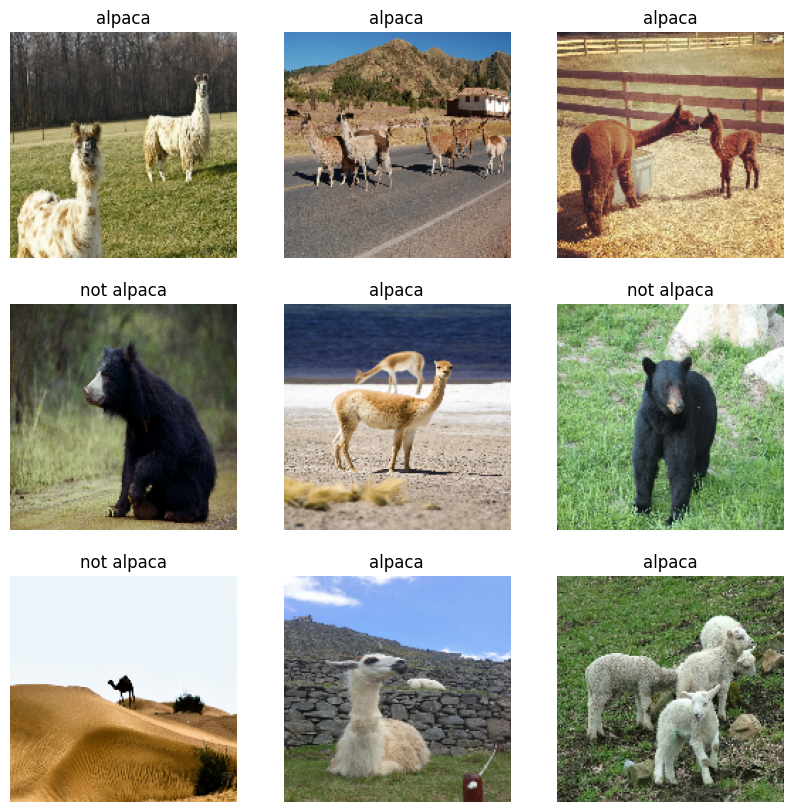

In [8]:
class_names = train_dataset.class_names  # Get class names

plt.figure(figsize=(10, 10))  # Set figure size
for images, labels in train_dataset.take(1):  # Iterate through the first batch of training data
    for i in range(9):  # Iterate through the first 9 images in the batch
        ax = plt.subplot(3, 3, i + 1)  # Create subplot
        plt.imshow(images[i].numpy().astype("uint8"))  # Display image
        plt.title(class_names[labels[i]])  # Set title as class name
        plt.axis("off")  # Turn off axis


Note: The original dataset has some mislabelled images in it as well.

<div style="background-color: #a83d36; color: #FFFFFF; padding: 10px; text-align: center; border-radius: 15px 15px 5px 5px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.5);">
  <h1 style="margin: 0; font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif; font-weight: bold; font-size: 32px;"> Data Preprocessing and Argumentation</h1>
</div>

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE  # Set AUTOTUNE for optimization

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)  # Prefetch data for optimization


In [10]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 data augmentation layers.
    Returns:
        tf.keras.Sequential: Sequential model for data augmentation.
    '''

    # Initialize a Sequential model for data augmentation
    data_augmentation = tf.keras.Sequential()

    # Add horizontal flipping layer
    data_augmentation.add(RandomFlip('horizontal'))

    # Add rotation layer with a maximum rotation of 20%
    data_augmentation.add(RandomRotation(0.2))

    return data_augmentation


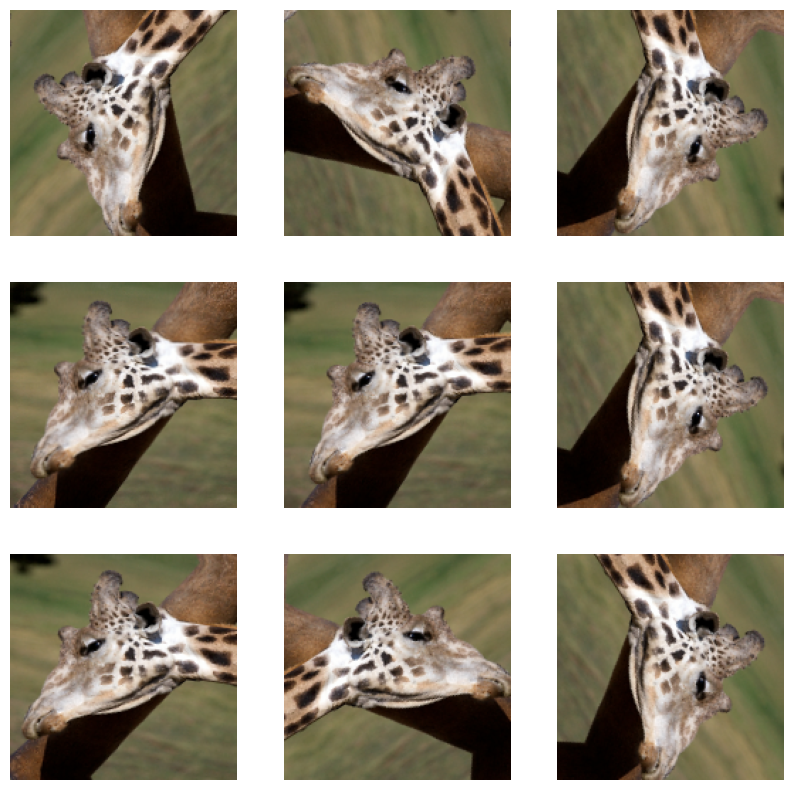

In [11]:
data_augmentation = data_augmenter()  # Initialize data augmentation model

for image, _ in train_dataset.take(1):  # Iterate through the first batch of training images
    plt.figure(figsize=(10, 10))  # Set figure size
    first_image = image[0]  # Get the first image in the batch
    for i in range(9):  # Iterate to display the first 9 augmented images
        ax = plt.subplot(3, 3, i + 1)  # Create subplot
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))  # Apply data augmentation
        plt.imshow(augmented_image[0] / 255)  # Display augmented image
        plt.axis('off')  # Turn off axis


<div style="background-color: #a83d36; color: #FFFFFF; padding: 10px; text-align: center; border-radius: 15px 15px 5px 5px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.5);">
  <h1 style="margin: 0; font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif; font-weight: bold; font-size: 32px;"> Using MobileNetV2 for Transfer Learning</h1>
</div>

<div style="text-align:center;">
<img src="images/mobilenetv2.png" style="width:650px;height:450px;">
</div>

In [16]:
# Define preprocess_input function
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input 

In [17]:
IMG_SHAPE = IMG_SIZE + (3,)  # Define image shape

# Initialize MobileNetV2 model

base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,  
    include_top=True,  
    weights='imagenet'  
)


In [18]:
# Print the model summary
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [12]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


In [20]:
# Print the last two layers name
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d_1
predictions


Note the last 2 layers here. They are the so called top layers, and they are responsible of the classification in the model

<div style="background-color: #a83d36; color: #FFFFFF; padding: 10px; text-align: center; border-radius: 15px 15px 5px 5px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.5);">
  <h1 style="margin: 0; font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif; font-weight: bold; font-size: 32px;">  ALPACA_MODEL
</h1>
</div>

In [55]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    
    '''  
    Define a tf.keras model for binary classification out of the MobileNetV2 model
    
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
        
    Returns:
        tf.keras.model
        
    '''
    
    
    input_shape = image_shape + (3,)


    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    prediction_layer = tfl.Dense(1)
    outputs = prediction_layer(x) 
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [56]:
# Initialize model using alpaca_model function with specified image size and data augmentation

model2 = alpaca_model(IMG_SIZE, data_augmentation)

In [57]:
base_learning_rate = 0.001  # Set base learning rate

model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),  # Compile the model with Adam optimizer and specified learning rate
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  # Use Binary Crossentropy loss function
    metrics=['accuracy']  # Monitor accuracy during training
)  # Compile the model


In [58]:
initial_epochs = 5  # Set number of initial epochs for training

history = model2.fit(
    train_dataset,  # Training dataset
    validation_data=validation_dataset,  # Validation dataset
    epochs=initial_epochs  # Number of epochs for training
)  # Fit the model


Epoch 1/5
9/9 [==============================] - 7s 479ms/step - loss: 0.7451 - accuracy: 0.5191 - val_loss: 0.5632 - val_accuracy: 0.6615
Epoch 2/5
9/9 [==============================] - 4s 399ms/step - loss: 0.5537 - accuracy: 0.6870 - val_loss: 0.4073 - val_accuracy: 0.8154
Epoch 3/5
9/9 [==============================] - 4s 418ms/step - loss: 0.4801 - accuracy: 0.7786 - val_loss: 0.3615 - val_accuracy: 0.8154
Epoch 4/5
9/9 [==============================] - 5s 485ms/step - loss: 0.4326 - accuracy: 0.7863 - val_loss: 0.3306 - val_accuracy: 0.8308
Epoch 5/5
9/9 [==============================] - 5s 425ms/step - loss: 0.3779 - accuracy: 0.7939 - val_loss: 0.3212 - val_accuracy: 0.8000


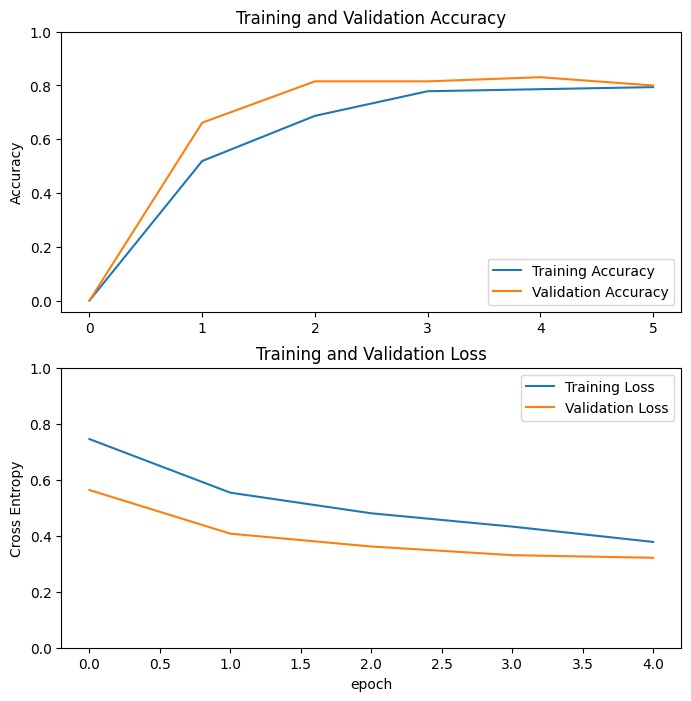

In [59]:
acc = [0.] + history.history['accuracy']  # Training accuracy
val_acc = [0.] + history.history['val_accuracy']  # Validation accuracy

loss = history.history['loss']  # Training loss
val_loss = history.history['val_loss']  # Validation loss

plt.figure(figsize=(8, 8))  # Set figure size
plt.subplot(2, 1, 1)  # First subplot for accuracy
plt.plot(acc, label='Training Accuracy')  # Plot training accuracy
plt.plot(val_acc, label='Validation Accuracy')  # Plot validation accuracy
plt.legend(loc='lower right')  # Add legend
plt.ylabel('Accuracy')  # Label for y-axis
plt.ylim([min(plt.ylim()),1])  # Set y-axis limit
plt.title('Training and Validation Accuracy')  # Title of the plot

plt.subplot(2, 1, 2)  # Second subplot for loss
plt.plot(loss, label='Training Loss')  # Plot training loss
plt.plot(val_loss, label='Validation Loss')  # Plot validation loss
plt.legend(loc='upper right')  # Add legend
plt.ylabel('Cross Entropy')  # Label for y-axis
plt.ylim([0,1.0])  # Set y-axis limit
plt.title('Training and Validation Loss')  # Title of the plot
plt.xlabel('epoch')  # Label for x-axis
plt.show()  # Show the plot


<div style="background-color: #a83d36; color: #FFFFFF; padding: 10px; text-align: center; border-radius: 15px 15px 5px 5px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.5);">
  <h1 style="margin: 0; font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif; font-weight: bold; font-size: 32px;">  FINE-TUNING THE MODEL
</h1>
</div>

In [60]:
base_model = model2.layers[4]  # Get the base model from the 5th layer of model2
base_model.trainable = True  # Set the base model to be trainable

print("Number of layers in the base model: ", len(base_model.layers))  # Print the number of layers in the base model

fine_tune_at = 120  # Define the layer from which fine-tuning will start

# Freeze all layers before the fine_tune_at layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Define loss function (BinaryCrossentropy) with from_logits=True
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Define optimizer (Adam) with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate * 0.1)

# Define evaluation metric as accuracy
metrics = ['accuracy']

# Compile the model with defined loss function, optimizer, and metrics
model2.compile(
    loss=loss_function,
    optimizer=optimizer,
    metrics=metrics
)


Number of layers in the base model:  154


In [61]:
fine_tune_epochs = 5  # Number of epochs for fine-tuning
total_epochs =  initial_epochs + fine_tune_epochs  # Total number of epochs

history_fine = model2.fit(
    train_dataset,  # Training dataset
    epochs=total_epochs,  # Total number of epochs
    initial_epoch=history.epoch[-1],  # Start epoch from the last epoch of previous training
    validation_data=validation_dataset  # Validation dataset
)  # Fit the model for fine-tuning


Epoch 5/10
9/9 [==============================] - 10s 591ms/step - loss: 0.5014 - accuracy: 0.7519 - val_loss: 0.2813 - val_accuracy: 0.8154
Epoch 6/10
9/9 [==============================] - 6s 542ms/step - loss: 0.3520 - accuracy: 0.7863 - val_loss: 0.1758 - val_accuracy: 0.9538
Epoch 7/10
9/9 [==============================] - 6s 570ms/step - loss: 0.3330 - accuracy: 0.8206 - val_loss: 0.1321 - val_accuracy: 0.9846
Epoch 8/10
9/9 [==============================] - 6s 571ms/step - loss: 0.2825 - accuracy: 0.8588 - val_loss: 0.2105 - val_accuracy: 0.8769
Epoch 9/10
9/9 [==============================] - 6s 529ms/step - loss: 0.2116 - accuracy: 0.9046 - val_loss: 0.1066 - val_accuracy: 0.9692
Epoch 10/10
9/9 [==============================] - 5s 529ms/step - loss: 0.1582 - accuracy: 0.9542 - val_loss: 0.0761 - val_accuracy: 0.9692


In [62]:
acc += history_fine.history['accuracy']  # Append fine-tuning training accuracy to previous accuracy
val_acc += history_fine.history['val_accuracy']  # Append fine-tuning validation accuracy to previous validation accuracy

loss += history_fine.history['loss']  # Append fine-tuning training loss to previous loss
val_loss += history_fine.history['val_loss']  # Append fine-tuning validation loss to previous loss


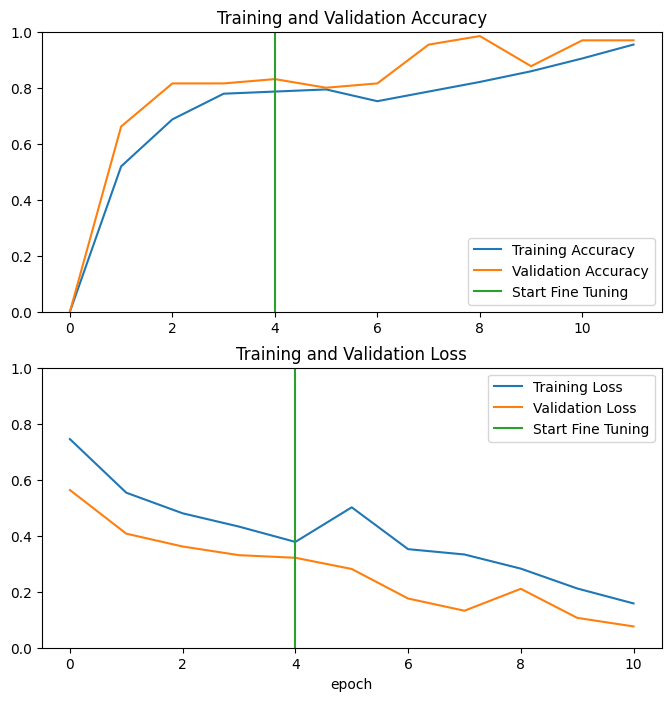

In [63]:
plt.figure(figsize=(8, 8))  # Set figure size

# Subplot for accuracy
plt.subplot(2, 1, 1)  
plt.plot(acc, label='Training Accuracy')  # Plot training accuracy
plt.plot(val_acc, label='Validation Accuracy')  # Plot validation accuracy
plt.ylim([0, 1])  # Set y-axis limit
plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')  # Indicate start of fine-tuning
plt.legend(loc='lower right')  # Add legend
plt.title('Training and Validation Accuracy')  # Title of the plot

# Subplot for loss
plt.subplot(2, 1, 2)  
plt.plot(loss, label='Training Loss')  # Plot training loss
plt.plot(val_loss, label='Validation Loss')  # Plot validation loss
plt.ylim([0, 1.0])  # Set y-axis limit
plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')  # Indicate start of fine-tuning
plt.legend(loc='upper right')  # Add legend
plt.title('Training and Validation Loss')  # Title of the plot
plt.xlabel('epoch')  # Label for x-axis

plt.show()  # Show the plot
